# Arithmetic Contest - Prototyping with CNN

- **Author**: Michael Yuan
- **Team**: 一朵小红花

In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

### 数据预处理

1.读取文本信息

In [106]:
import numpy as np
with open('.\image_contest_level_1\labels.txt', 'r') as f:
    labels = f.readlines()

# X = expr
# Y = result
x, y = [], []
for line in labels:
    splited = line.split(' ')
    x.append(splited[0])
    y.append(splited[1])
    
x_set = np.array(x).reshape(10, -1)
y_set = np.array(y).reshape(10, -1)

2.读取图片信息

In [122]:
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

img_db = []
for set_i in range(10):
    img_db.append([])
    for i in tqdm(range(10000)):
        img = Image.open('C:\\image_contest_level_1\\' + str(i + 10000 * set_i) + '.png').convert('RGB')
        img_db[set_i].append(np.array(img))

100%|████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1834.73it/s]


In [123]:
np.array(img_db[0]).shape

(10000, 60, 180, 3)

### 序列化导出为Pickle文件

- 用pickle将十万张图片序列化为十个pickle文件。
- 每个文件是一个dict对象。
- 该dict对象具有4个键
    - set_id：指示dict所含数据的批号
    - data：np.array，维度是(1000, 60, 180, 30)
    - expr：一万个文本表达式，与data的图像一一对应
    - res：一万个文本结果，与data的图像一一对应

In [124]:
import pickle

for i in tqdm(range(10)):
    obj = {'set_id':i, 'data':np.array(img_db[i]), 'expr':x_set[i], 'res':y_set[i]}
    with open('test_data_%s.p'%(i), 'wb') as f:
        pickle.dump(obj, f)

100%|████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.32s/it]


### 导入Pickle文件的数据

In [2]:
# 提供pickle文件所在位置，以及要取的数据集编号（0-9）
def load_dataset(path, set_id):
    if set_id > 9 or set_id < 0:
        print('Error: Invalid Dataset ID. Range 0 to 9.')
        return None
    with open('%stest_data_%s.p'%(path, set_id), mode='rb') as file:
        dataset = pickle.load(file)

    features = dataset['data']
    labels = np.array(dataset['expr'])
    results = np.array(dataset['res'])
    print('Features Shape :', features.shape)
    print('Expressions Shape :', labels.shape)
    print('Results Shape :', results.shape)

    return features, labels, results

In [12]:
features, labels, results = load_dataset('', 0)

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)


### 确定字符集

- 数字：10种
- 括号：2种
- 运算符：3种，不包括除法
- 空白符：1种，用来补齐没有使用括号的图片，这样所有图片中的字符串长度都可以统一固定为7。
    - 例如：1+7-1 （原长度为5）可以被识别为 1+_7-1_ （长度为7）

In [2]:
# 字符集
char_set = '0123456789+-*() '

# 字符集长度 = 16
n_class = len(char_set)

# 图片所含文本内容的长度 = 7
n_len = 7

# 图片尺寸
width, height = 180, 60

### 对Expression内容进行One-Hot编码和解码

In [149]:
len(labels)

10000

In [3]:
def encode(y):
    y_encoded = [np.zeros((len(y), n_class), dtype=np.uint8) for i in range(n_len)]
    for pid in range(len(y)):
        for i, ch in enumerate(y[pid]):
            y_encoded[i][pid, char_set.find(ch)] = 1
        if len(y[pid]) < n_len:
            y_encoded[5][pid, 15] = 1
            y_encoded[6][pid, 15] = 1
    return y_encoded

In [4]:
def decode(y, i=0):
    y = np.argmax(np.array(y), axis=2)
    y = y[:,i]
    return ''.join([char_set[x] for x in y])

In [14]:
encoded_labels = encode(labels)
print("Length :", len(encoded_labels))
print("Shape in Numpy :", np.array(encoded_labels).shape)
print("Example Label :", np.array(labels)[0])
print("Example Encoded Label : \n", np.array(encoded_labels)[:, 0, :])

Length : 7
Shape in Numpy : (7, 10000, 16)
Example Label : (4*8)+8
Example Encoded Label : 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


In [208]:
decode(encoded_labels, 2)

'5+(5+2)'

### 搭建卷积神经网络

In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

#CCM -> CCM -> CCM -> CCM -> Flatten -> Dropout -> Fully-Connected X 4 -> output
def create_model(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    # Convolution + Pooling Layer (4层CCM级联，模拟VGG16的结构)
    # 32C 32C M -> 64C 64C M -> 128C 128C M -> 256C 256C M
    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    # Flatten
    x = Flatten()(x)
    # Dropout
    x = Dropout(0.25)(x)
    # Fully-Connected Layer (由于需要识别的字符数量是4，因此需要用4个全链接子网)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]

    model = Model(inputs=input_tensor, outputs=x, name='captcha')
    return model

Using TensorFlow backend.


### 初始化模型

In [252]:
from helper import make_parallel
from keras.callbacks import EarlyStopping, TensorBoard, History

# 1. Create Model (3 CCM)
model = create_model(3, 32)

# 2. Enable Data Parallelism
# model = make_parallel(model, 2)

# 3. Compile Model with metrics/optimizer/loss
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

### 训练模型

In [216]:
# the number of samples processed for each epoch is batch_size * steps_per_epochs
batch_size = 64
epoch = 1

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

# Start training
model.fit(x=features, 
          y=encoded_labels, 
          batch_size=batch_size, 
          epochs=epoch, 
          verbose=1, 
          callbacks=None)

Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.2604 - c1_loss: 0.0081 - c2_loss: 0.0281 - c3_loss: 0.0398 - c4_loss: 0.0674 - c5_loss: 0.0534 - c6_loss: 0.0462 - c7_loss: 0.0173 - c1_acc: 0.9980 - c2_acc: 0.9900 - c3_acc: 0.9881 - c4_acc: 0.9784 - c5_acc: 0.9831 - c6_acc: 0.9847 - c7_acc: 0.9959    


In [285]:
total_dataset_to_be_trained = 9

for set_id in tqdm(range(total_dataset_to_be_trained)):
    features, labels, results = load_dataset('', set_id)
    encoded_labels = encode(labels)
    model.fit(x=features, 
              y=encoded_labels, 
              batch_size=batch_size, 
              epochs=epoch, 
              verbose=1, 
              callbacks=None)

  0%|                                                                      | 0/9 [00:00<?, ?it/s]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0240 - c1_loss: 2.2310e-04 - c2_loss: 0.0016 - c3_loss: 0.0071 - c4_loss: 0.0052 - c5_loss: 0.0045 - c6_loss: 0.0041 - c7_loss: 0.0012 - c1_acc: 1.0000 - c2_acc: 0.9995 - c3_acc: 0.9983 - c4_acc: 0.9986 - c5_acc: 0.9986 - c6_acc: 0.9989 - c7_acc: 0.9995    


 11%|██████▉                                                       | 1/9 [00:16<02:09, 16.25s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0192 - c1_loss: 2.3303e-04 - c2_loss: 0.0015 - c3_loss: 0.0019 - c4_loss: 0.0075 - c5_loss: 0.0030 - c6_loss: 0.0038 - c7_loss: 0.0013 - c1_acc: 1.0000 - c2_acc: 0.9995 - c3_acc: 0.9995 - c4_acc: 0.9981 - c5_acc: 0.9990 - c6_acc: 0.9989 - c7_acc: 0.9997    


 22%|█████████████▊                                                | 2/9 [00:32<01:53, 16.21s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0144 - c1_loss: 2.6805e-04 - c2_loss: 7.2792e-04 - c3_loss: 0.0035 - c4_loss: 0.0039 - c5_loss: 0.0028 - c6_loss: 0.0024 - c7_loss: 7.2206e-04 - c1_acc: 0.9999 - c2_acc: 0.9999 - c3_acc: 0.9987 - c4_acc: 0.9986 - c5_acc: 0.9994 - c6_acc: 0.9995 - c7_acc: 0.9999    


 33%|████████████████████▋                                         | 3/9 [00:48<01:37, 16.20s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0194 - c1_loss: 8.8302e-04 - c2_loss: 0.0010 - c3_loss: 0.0020 - c4_loss: 0.0068 - c5_loss: 0.0035 - c6_loss: 0.0034 - c7_loss: 0.0018 - c1_acc: 0.9998 - c2_acc: 0.9997 - c3_acc: 0.9995 - c4_acc: 0.9986 - c5_acc: 0.9990 - c6_acc: 0.9985 - c7_acc: 0.9994    


 44%|███████████████████████████▌                                  | 4/9 [01:04<01:21, 16.21s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0217 - c1_loss: 4.6253e-04 - c2_loss: 0.0010 - c3_loss: 0.0041 - c4_loss: 0.0057 - c5_loss: 0.0042 - c6_loss: 0.0038 - c7_loss: 0.0025 - c1_acc: 0.9999 - c2_acc: 0.9998 - c3_acc: 0.9988 - c4_acc: 0.9986 - c5_acc: 0.9992 - c6_acc: 0.9992 - c7_acc: 0.9993    


 56%|██████████████████████████████████▍                           | 5/9 [01:20<01:04, 16.20s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0103 - c1_loss: 5.7447e-05 - c2_loss: 0.0016 - c3_loss: 6.1620e-04 - c4_loss: 0.0034 - c5_loss: 0.0021 - c6_loss: 0.0018 - c7_loss: 7.0486e-04 - c1_acc: 1.0000 - c2_acc: 0.9998 - c3_acc: 0.9999 - c4_acc: 0.9990 - c5_acc: 0.9995 - c6_acc: 0.9995 - c7_acc: 0.9997    


 67%|█████████████████████████████████████████▎                    | 6/9 [01:37<00:48, 16.19s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0099 - c1_loss: 1.7225e-04 - c2_loss: 4.4842e-04 - c3_loss: 9.9522e-04 - c4_loss: 0.0035 - c5_loss: 0.0021 - c6_loss: 0.0022 - c7_loss: 4.6250e-04 - c1_acc: 0.9999 - c2_acc: 0.9999 - c3_acc: 0.9998 - c4_acc: 0.9992 - c5_acc: 0.9993 - c6_acc: 0.9991 - c7_acc: 0.9999    


 78%|████████████████████████████████████████████████▏             | 7/9 [01:53<00:32, 16.18s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0092 - c1_loss: 5.1499e-05 - c2_loss: 3.2140e-04 - c3_loss: 0.0014 - c4_loss: 0.0032 - c5_loss: 0.0016 - c6_loss: 0.0022 - c7_loss: 2.9635e-04 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 0.9995 - c4_acc: 0.9988 - c5_acc: 0.9996 - c6_acc: 0.9993 - c7_acc: 1.0000    


 89%|███████████████████████████████████████████████████████       | 8/9 [02:09<00:16, 16.18s/it]

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Epoch 1/1
10000/10000 [==============================] - 15s - loss: 0.0085 - c1_loss: 9.3618e-05 - c2_loss: 0.0015 - c3_loss: 6.3416e-04 - c4_loss: 0.0020 - c5_loss: 0.0015 - c6_loss: 0.0024 - c7_loss: 2.8852e-04 - c1_acc: 1.0000 - c2_acc: 0.9994 - c3_acc: 0.9999 - c4_acc: 0.9993 - c5_acc: 0.9997 - c6_acc: 0.9991 - c7_acc: 1.0000    


100%|██████████████████████████████████████████████████████████████| 9/9 [02:25<00:00, 16.21s/it]


In [284]:
# 保存模型(需要安装h5py)
model.save('arithmetic_9set_2epoch_9895.h5')

In [ ]:
del model

In [5]:
# 重新载入模型
from keras.models import load_model
model = load_model('arithmetic_9set_2epoch_9895.h5')

### 检测模型性能

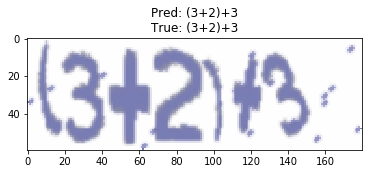

In [17]:
# 可视化对单个验证码的预测准确与否
import random
pid = random.choice(range(10000))
x, y_true = (features[pid].reshape(1, 60, 180, 3), np.array(encoded_labels)[:, pid, :].reshape(7, 1, 16))
y_pred = model.predict(x)
pred = "Pred: " + decode(y_pred)
true = "True: " + decode(y_true)
plt.imshow(x[0])
plt.title(pred + "\n" + true)
plt.show()

In [308]:
def evaluate(model, features, encoded_labels, batch_size=10000):
    selected_id = random.sample(range(10000), batch_size)
    s_pic = np.array([features[x] for x in selected_id])
    s_label = []
    for letter_id in range(n_len):
        letter_slice = np.array([encoded_labels[letter_id][x, :] for x in selected_id])
        s_label.append(letter_slice)
    batch_acc = 0
    y_pred = model.predict(s_pic)
#     print(np.array(y_pred).shape)
#     print(np.array(s_label).shape)
    y_pred = np.argmax(y_pred, axis=2).T
    y_true = np.argmax(s_label, axis=2).T
    batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred)))
    print("Test Accuracy over", batch_size, "samples :", batch_acc)

features, labels, results = load_dataset('', 9)
encoded_labels = encode(labels)
evaluate(model, features, encoded_labels, 10000)

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)
Test Accuracy over 10000 samples : 0.9895


In [18]:
y_pred = model.predict(features)
np.array(y_pred).shape

(7, 10000, 16)

In [19]:
y_decode = np.argmax(y_pred, axis=2).T
y_decode.shape

(10000, 7)

In [21]:
for i in range(10):
    s = "".join([char_set[x] for x in y_decode[i, :]])
    print(s)

(4*8)+8
7+3*0  
5+(5+2)
(8-0)-8
0+(0+2)
(2*5)+0
0+(1+8)
2+(4+9)
7*2+4  
0-(7*1)


### 对测试集进行预测并输出

In [22]:
n_validation = 200000
batch = 10000
n_batch = int(n_validation / batch)

y_all_text = []
y_all_res = []
for i_batch in range(n_batch):
    img_db = []
    for i in tqdm(range(batch), desc="Loading Batch #" + str(i_batch)):
        img = Image.open('C:\\image_contest_level_1_validate\\' + str(i + batch * i_batch) + '.png').convert('RGB')
        img_db.append(np.array(img, dtype=np.uint8))
    x_pred = np.array(img_db)
    
    # Predict Using Trained Model
    y_pred = model.predict(x_pred)
    y_decode = np.argmax(y_pred, axis=2).T
    
    # Decode and store text expression
    y_text = []
    for i in tqdm(range(batch), desc="Decoding Batch #" + str(i_batch)):
        y_text.append("".join([char_set[x] for x in y_decode[i, :]]))

    # Calculate the result of the expression
    y_res = []
    for i in tqdm(range(batch), desc="Calculating Batch #" + str(i_batch)):
        val = 0
        try:
            val = eval(y_text[i])
        except Exception as e:
            print("Invalid Expression")
        y_res.append(val)

    y_all_text += y_text
    y_all_res += y_res

Calculating Batch #0:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #0:  62%|██████████████████▌           | 6168/10000 [00:00<00:00, 61602.95it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #1:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #1:  68%|████████████████████▍         | 6794/10000 [00:00<00:00, 67854.65it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #2:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #2:  48%|██████████████▍               | 4819/10000 [00:00<00:00, 48130.03it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #2:  93%|███████████████████████████▉  | 9303/10000 [00:00<00:00, 47074.73it/s]

Invalid Expression


Calculating Batch #3:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #3:  55%|████████████████▌             | 5515/10000 [00:00<00:00, 55081.11it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #4:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #4:  51%|███████████████▍              | 5144/10000 [00:00<00:00, 51375.99it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #5:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #5:  50%|███████████████               | 5033/10000 [00:00<00:00, 50267.01it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #6:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #6:  57%|█████████████████             | 5681/10000 [00:00<00:00, 56610.97it/s]

Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #7:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #7:  46%|█████████████▊                | 4613/10000 [00:00<00:00, 46072.59it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #7:  89%|██████████████████████████▊   | 8918/10000 [00:00<00:00, 44822.18it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #8:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #8:  49%|██████████████▊               | 4925/10000 [00:00<00:00, 49188.95it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #9:   0%|                                            | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #9:  48%|██████████████▎               | 4751/10000 [00:00<00:00, 47450.76it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #10:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #10:  56%|████████████████▏            | 5587/10000 [00:00<00:00, 55800.87it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #11:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #11:  45%|█████████████▏               | 4534/10000 [00:00<00:00, 45282.93it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #11:  95%|███████████████████████████▌ | 9517/10000 [00:00<00:00, 46541.18it/s]

Invalid Expression


Calculating Batch #12:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #12:  52%|███████████████              | 5203/10000 [00:00<00:00, 51965.75it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #12:  99%|████████████████████████████▌| 9862/10000 [00:00<00:00, 50206.70it/s]

Invalid Expression


Calculating Batch #13:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #13:  57%|████████████████▌            | 5695/10000 [00:00<00:00, 56879.13it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #14:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #14:  49%|██████████████▏              | 4872/10000 [00:00<00:00, 48659.60it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #15:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #15:  46%|█████████████▍               | 4635/10000 [00:00<00:00, 46291.99it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #15:  90%|██████████████████████████▏  | 9025/10000 [00:00<00:00, 45529.67it/s]

Invalid Expression
Invalid Expression


Calculating Batch #16:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #16:  52%|███████████████▏             | 5245/10000 [00:00<00:00, 52384.36it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #17:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #17:  40%|███████████▍                 | 3950/10000 [00:00<00:00, 39357.59it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #17:  82%|███████████████████████▊     | 8193/10000 [00:00<00:00, 40217.22it/s]

Invalid Expression
Invalid Expression


Calculating Batch #18:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #18:  48%|█████████████▉               | 4824/10000 [00:00<00:00, 48179.05it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #18:  89%|█████████████████████████▉   | 8949/10000 [00:00<00:00, 45848.69it/s]

Invalid Expression
Invalid Expression


Calculating Batch #19:   0%|                                           | 0/10000 [00:00<?, ?it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #19:  53%|███████████████▎             | 5295/10000 [00:00<00:00, 52884.11it/s]

Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression
Invalid Expression


Calculating Batch #19: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 51481.92it/s]


In [24]:
print("Expressions:", len(y_all_text))
print("Results:", len(y_all_res))

Expressions: 200000
Results: 200000


### 将预测的运算表达式文本与相应计算结果合并输出为txt文件

In [32]:
with open('validation_result.txt', 'w') as f:
    for i in tqdm(range(n_validation), desc='Write #' + str(i) + " to file"):
        line = str(y_all_text[i].replace(" ", "")) + ' ' + str(y_all_res[i]) + '\n'
        f.writelines(line)

Write #199999 to file: 100%|█████████████████████████| 200000/200000 [00:01<00:00, 140892.52it/s]


#### 第一次提交的准确率分数为 0.988915.

## Solution 2：使用CTC进一步提高准确率

In [3]:
# 字符集：去掉空格
char_set = '0123456789+-*() '

# 字符集长度 = 15
n_class = len(char_set)

# 图片所含文本内容的长度 = 7
n_len = 7

# 图片尺寸
width, height = 180, 60

In [103]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 数据预处理

In [20]:
# 提供pickle文件所在位置，以及要取的数据集编号（0-9）
def load_dataset(path, set_id):
    if set_id > 9 or set_id < 0:
        print('Error: Invalid Dataset ID. Range 0 to 9.')
        return None
    with open('%stest_data_%s.p'%(path, set_id), mode='rb') as file:
        dataset = pickle.load(file)

    features = dataset['data']
    labels = np.array(dataset['expr'])
    results = np.array(dataset['res'])
#     print('Features Shape :', features.shape)
#     print('Expressions Shape :', labels.shape)
#     print('Results Shape :', results.shape)

    return features, labels, results

In [6]:
features, labels, results = load_dataset('', 0)

Features Shape : (10000, 60, 180, 3)
Expressions Shape : (10000,)
Results Shape : (10000,)


In [70]:
def preprocess(features, labels, scan, test_mode=False):
    size = len(labels)
    x = np.array(features, dtype=np.uint8).transpose(0, 2, 1, 3)
    y = np.ones((size, n_len), dtype=np.uint8)
    if not test_mode:
        for i in range(size):
            tmp = labels[i]
            if len(tmp) < n_len:
                tmp = tmp + '  '
            y[i] = [char_set.find(ch) for ch in tmp]
    return [x, 
            y, 
            scan * np.ones(size),
            n_len * np.ones(size)], np.ones(size)
[x, y, _, _], _ = preprocess(features, labels, int(conv_shape[1] - 2))
y[:10]

array([[13,  9, 12,  7, 14, 11,  4],
       [ 9, 11,  6, 10,  3, 15, 15],
       [13,  9, 12,  6, 14, 11,  2],
       [ 0, 11,  8, 11,  7, 15, 15],
       [13,  1, 10,  4, 14, 10,  3],
       [13,  6, 11,  2, 14, 11,  1],
       [ 2, 11,  8, 11,  7, 15, 15],
       [ 1, 12, 13,  3, 12,  4, 14],
       [ 9, 12,  6, 11,  2, 15, 15],
       [ 1, 12, 13,  5, 12,  9, 14]], dtype=uint8)

### 定义模型

In [117]:
from keras.models import *
from keras.layers import *
from keras.layers.merge import Concatenate, Add
rnn_size = 128

def create_model_CTC(num_CCM, num_kernel):
    input_tensor = Input((width, height, 3))
    x = input_tensor
    
    # 卷积池化层
    for i in range(num_CCM):
        x = Conv2D(filters=num_kernel, kernel_size=3, strides=1, activation='relu')(x)
#         x = BatchNormalization()(x)
        x = Conv2D(filters=num_kernel, kernel_size=3, strides=1, activation='relu')(x)
#         x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
        
    # 全链接层
    conv_shape = x.get_shape()
    x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
    x = Dense(32, activation='relu')(x)
    
    # GRU层
    gru_1 = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
    gru_1b = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1_b', go_backwards=True)(x)
    gru1_merged = Add()([gru_1, gru_1b])
    
    gru_2 = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2_b', go_backwards=True)(gru1_merged)
    x = Concatenate()([gru_2, gru_2b])
    
    # Dropout层
    x = Dropout(0.25)(x)
    
    # 输出层：16类（字符集15类 + 空白符1类）
    x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
    
    # 基模型定义完成：卷积层 > 全链接 > GRU > Dropout > 输出层
    base_model = Model(inputs=input_tensor, outputs=x)
    
    # CTC层，输出CTC Loss
    labels = Input(name='the_labels', shape=[n_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    loss_out = Lambda(function=ctc_lambda_func, output_shape=[1], name='ctc')([x, labels, input_length, label_length])
    
    # CTC模型定义完成
    ctc_model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
    
    return conv_shape, base_model, ctc_model

### 初始化模型

In [118]:
def loss_func(y_true, y_pred):
    return y_pred

In [156]:
# 1. 创建模型：3层卷积池化级联 / 32个卷积核
conv_shape, base_model, model = create_model_CTC(3, 32)

# 2. 编译模型
model.compile(loss={'ctc': loss_func}, optimizer='adadelta')
# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')

In [9]:
print(conv_shape)

(?, 19, 4, 32)


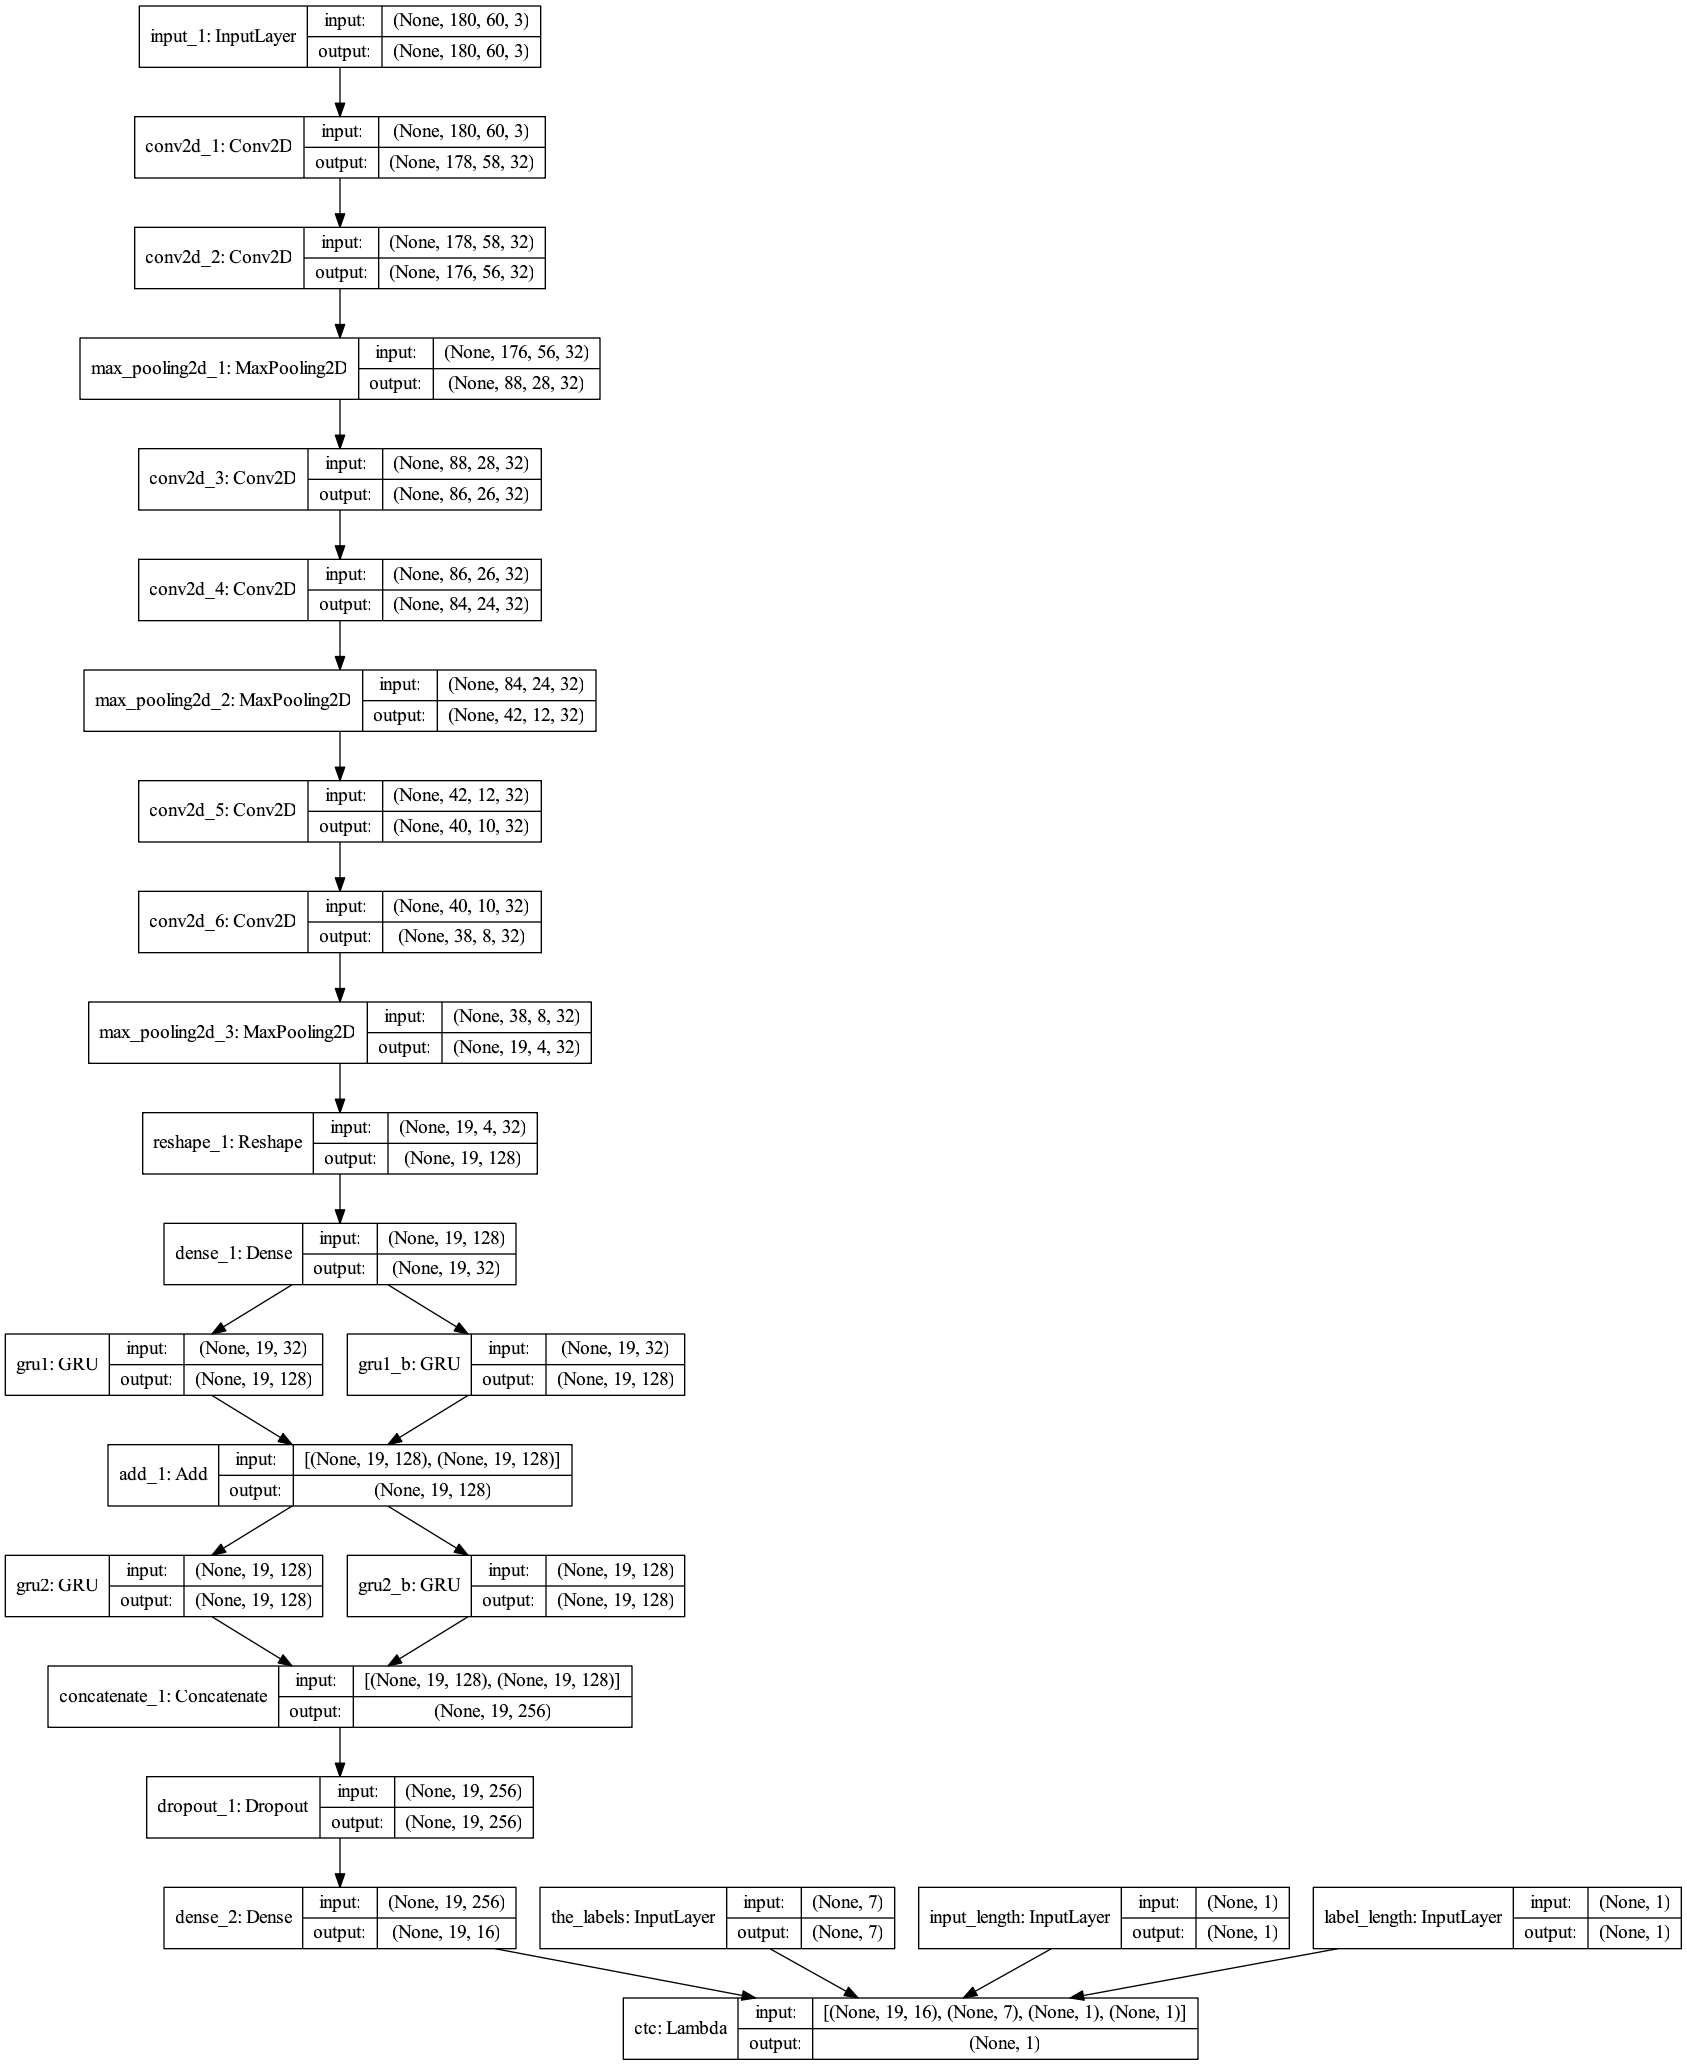

In [10]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="ctc_model.png", show_shapes=True)
Image('ctc_model.png')

### 训练模型

In [188]:
from datetime import datetime
def get_time():
    return datetime.now().strftime("%Y%m%d@%H-%M-%S")

In [191]:
epoch = 1

In [221]:
total_dataset_to_be_trained = 10
batch_size = 64
import random

for set_id in range(total_dataset_to_be_trained):
    print("Training Data Set #", set_id)
    features, labels, results = load_dataset('', set_id)
    scan = int(conv_shape[1] - 2)
    [x, y, I, L], T = preprocess(features, labels, scan)
    model.fit(x=[x, y, I, L], 
              y=T, 
              batch_size=batch_size, 
              epochs=1,
              callbacks=None)
    # 计算模型准确度
    acc = 100 * evaluate(model, size=10000, set_id=random.choice(range(10)))
    # 保存模型参数
    base_model.save('%s_ctc2_10set_%s_epoch_%s_acc.h5' % (get_time(), epoch, acc))
epoch += 1

Training Data Set # 0
Epoch 1/1
10000/10000 [==============================] - 23s - loss: 0.0067    
Accuracy over 10000 samples : 0.9985
Training Data Set # 1
Epoch 1/1
10000/10000 [==============================] - 22s - loss: 0.0126    
Accuracy over 10000 samples : 0.9976
Training Data Set # 2
Epoch 1/1
10000/10000 [==============================] - 21s - loss: 0.0099    
Accuracy over 10000 samples : 0.9978
Training Data Set # 3
Epoch 1/1
10000/10000 [==============================] - 21s - loss: 0.0113    
Accuracy over 10000 samples : 0.9992
Training Data Set # 4
Epoch 1/1
10000/10000 [==============================] - 21s - loss: 0.0280    
Accuracy over 10000 samples : 0.9977
Training Data Set # 5
Epoch 1/1
10000/10000 [==============================] - 21s - loss: 0.0134    
Accuracy over 10000 samples : 0.9761
Training Data Set # 6
Epoch 1/1
10000/10000 [==============================] - 21s - loss: 0.0131    
Accuracy over 10000 samples : 0.993
Training Data Set # 7
Epoch 

In [162]:
# 保存模型
base_model.save('arithmetic_ctc2_10set_4epoch_9984.h5')

In [203]:
# 查看当前模型所能达到的准确率
evaluate(model)

Accuracy over 10000 samples : 0.9985


0.99850000000000005

In [195]:
# 重新载入模型
from keras.models import load_model
base_model.load_weights('20170801@17-49-34_ctc2_10set_1_epoch_99.95_acc.h5')

### 评估模型性能

In [185]:
# 使用第十个10000张图片计算测试准确率
def evaluate(model, size=10000, set_id=9):
    features, labels, results = load_dataset('', set_id)
    scan = int(conv_shape[1] - 2)
    [X_test, y_test, _, _], _  = preprocess(features[:size], labels[:size], scan)
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = K.get_value(ctc_decode)[:, :n_len]
    batch_acc = 0
    for o in out:
        for i in range(len(o)):
            if o[i] == -1:
                o[i] = 15
    if out.shape[1] == n_len:
        batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
    print("Accuracy over %s samples :" % (size), batch_acc)
    return batch_acc

#### 批量检测

In [142]:
# 检查预测结果解码情况
size = 1000
features, labels, results = load_dataset('', 8)
scan = int(conv_shape[1] - 2)
[X_test, y_test, _, _], _  = preprocess(features[:size], labels[:size], scan)

# 使用CNN+GRU构成的基模型进行预测
y_pred = base_model.predict(X_test)
y_argmax = np.argmax(y_pred, axis=2)

shape = y_pred[:,2:,:].shape
ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
out = K.get_value(ctc_decode)[:, :n_len]

# 将-1恢复为空格15
for o in out:
    for i in range(len(o)):
        if o[i] == -1:
            o[i] = 15

print("id", "     ", "Original", "     ", "Predict", "    ", "CTC Code")
for i in range(size):
    pred = "".join([char_set[ch] for ch in out[i]])
    hard = "".join([char_set[ch] for ch in y_argmax[i]])
    if labels[i] != pred.replace(" ", ""):
        print(i, "     ", labels[i], "     ", pred, "    ", hard)            
            
batch_acc = 0
if out.shape[1] == n_len:
    batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
print("\nAccuracy over %s samples :" % (size), batch_acc * 100, "%")

id       Original       Predict      CTC Code
2       (9*6)-2       (9*5)-2      ((((99*   5))-- 2  
33       9*(0-6)       9+(01-6      ((9+  (((01-  6))  
43       (8*4)*3       (8+4)*3      ((((8+  44))*  3   
73       6-(7+7)       6-(7+17      (66-(((7+  17)))   
104       (3-5)*5       (3-5*5       (((3-- 55**  5     
159       (8*9)+3       (8*)+3       ((((8**  )))+  33  
182       3*6-3       7*6-3        ((7*  6---33       
183       6+1+4       6+7+4        6666+  77+  44     
189       7+(6-8)       7(6-8)       ((77  (((66-- 88)) 
231       6*(4*1)       6*(4*1       (66** (((44*  11   
254       4*5-3       4*5-34       (44*  555- 3   4   
276       4+1*7       4+(1*7       (44+ (1**  7       
293       1-8*6       1-8+6        ((1- 8++  6        
308       (5+8)+3       5+8)+3       ((55+  88))++ 33   
376       5+1-2       1+9-2        ((1+  9-22         
378       (1+0)-5       (+0)-5       ((((++  00))---55  
403       9*(9-8)       9*(9-85      (999*  (((9-- 85)) 
41

#### 汇总训练集中的识别错误图片

In [198]:
# 收集易错题，尝试进一步提高准确率
error_img = []
error_label = []

for set_id in range(10):
    size = 10000
    features, labels, results = load_dataset('', set_id)
    scan = int(conv_shape[1] - 2)
    [X_test, y_test, _, _], _  = preprocess(features[:size], labels[:size], scan)

    # 预测和解码
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = K.get_value(ctc_decode)[:, :n_len]

    # 将-1恢复为空格15
    for o in out:
        for i in range(len(o)):
            if o[i] == -1:
                o[i] = 15

    for i in range(size):
        pred = "".join([char_set[ch] for ch in out[i]])
        if labels[i] != pred.replace(" ", ""):
            error_img.append(features[i])
            error_label.append(labels[i])

    batch_acc = 0
    if out.shape[1] == n_len:
        batch_acc += ((y_test == out).sum(axis=1) == n_len).mean()
    print("Accuracy over %s samples :" % (size), batch_acc * 100, "%")

print("Error Samples to be trained :", len(error_img))

Accuracy over 10000 samples : 99.83 %
Accuracy over 10000 samples : 99.87 %
Accuracy over 10000 samples : 99.84 %
Accuracy over 10000 samples : 99.88 %
Accuracy over 10000 samples : 99.81 %
Accuracy over 10000 samples : 99.95 %
Accuracy over 10000 samples : 99.77 %
Accuracy over 10000 samples : 99.72 %
Accuracy over 10000 samples : 99.77 %
Accuracy over 10000 samples : 99.8 %
Error Samples to be trained : 176


In [204]:
err_features = np.array(error_img)
error_label = np.array(error_label)
scan = int(conv_shape[1] - 2)
[x, y, I, L], T = preprocess(err_features, error_label, scan)
model.fit(x=[x, y, I, L], 
          y=T, 
          batch_size=batch_size, 
          epochs=1, 
          verbose=1, 
          callbacks=None)
evaluate(model)

Epoch 1/1
176/176 [==============================] - 0s - loss: 0.4331     
Accuracy over 10000 samples : 0.9984


0.99839999999999995

### 对测试集进行预测并输出

In [218]:
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# 导出为pickle
val_db = []
for set_i in range(20):
    val_db.append([])
    for i in tqdm(range(10000)):
        img = Image.open('C:\\image_contest_level_1_validate\\' + str(i + 10000 * set_i) + '.png').convert('RGB')
        val_db[set_i].append(np.array(img, dtype=np.uint8))
        
for i in tqdm(range(20)):
    obj = {'set_id':i, 'data':np.array(val_db[i])}
    with open('validation_data_%s.p'%(i), 'wb') as f:
        pickle.dump(obj, f)

100%|████████████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.18s/it]


In [214]:
# 导入pickle
def load_validation_dataset(path, set_id):
    if set_id > 19 or set_id < 0:
        print('Error: Invalid Dataset ID. Range 0 to 9.')
        return None
    with open('%svalidation_data_%s.p'%(path, set_id), mode='rb') as file:
        dataset = pickle.load(file)
    features = dataset['data']

    return features

In [219]:
from time import time
n_validation = 200000
batch = 10000
n_batch = 20

y_all_text = []
y_all_res = []
err_id = []

start = time()
for i_batch in range(n_batch):
    # 从pickle文件导入
    features = load_validation_dataset('', i_batch)

    # Predict Using Trained Model
    scan = int(conv_shape[1] - 2)
    [X_test, _, _, _], _  = preprocess(features, _, scan, test_mode=True)
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = K.get_value(ctc_decode)[:, :n_len]
    for o in out:
        for i in range(len(o)):
            if o[i] == -1:
                o[i] = 15
    
    # Decode and store text expression
    y_text = []
    for i in range(batch):
        y_text.append("".join([char_set[ch] for ch in out[i]]))

    # Calculate the result of the expression
    y_res = []
    invalid_count = 0
    for i in tqdm(range(batch), desc="Calculating Batch #" + str(i_batch)):
        val = 0
        try:
            val = eval(y_text[i])
        except Exception as e:
            invalid_count += 1
            err_id.append(i + 10000 * i_batch)
#             print("Invalid Expression")
        y_res.append(val)
    print("Invalid Expression Count =", invalid_count)
    y_all_text += y_text
    y_all_res += y_res

print("Total Time:", time() - start)

Calculating Batch #0: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 10716.40it/s]


Invalid Expression Count = 11


Calculating Batch #1: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 10165.06it/s]


Invalid Expression Count = 7


Calculating Batch #2: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 12821.12it/s]


Invalid Expression Count = 12


Calculating Batch #3: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 12755.66it/s]


Invalid Expression Count = 11


Calculating Batch #4: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 13019.97it/s]


Invalid Expression Count = 8


Calculating Batch #5: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 12310.96it/s]


Invalid Expression Count = 15


Calculating Batch #6: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 13373.42it/s]


Invalid Expression Count = 11


Calculating Batch #7: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 13205.56it/s]


Invalid Expression Count = 14


Calculating Batch #8: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 13214.77it/s]


Invalid Expression Count = 18


Calculating Batch #9: 100%|█████████████████████████████| 10000/10000 [00:00<00:00, 13265.12it/s]


Invalid Expression Count = 16


Calculating Batch #10: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 13202.66it/s]


Invalid Expression Count = 12


Calculating Batch #11: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 13001.75it/s]


Invalid Expression Count = 11


Calculating Batch #12: 100%|█████████████████████████████| 10000/10000 [00:01<00:00, 9093.75it/s]


Invalid Expression Count = 11


Calculating Batch #13: 100%|█████████████████████████████| 10000/10000 [00:01<00:00, 9020.28it/s]


Invalid Expression Count = 18


Calculating Batch #14: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 12964.92it/s]


Invalid Expression Count = 7


Calculating Batch #15: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 13098.64it/s]


Invalid Expression Count = 11


Calculating Batch #16: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 12822.76it/s]


Invalid Expression Count = 6


Calculating Batch #17: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 13015.49it/s]


Invalid Expression Count = 9


Calculating Batch #18: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 13487.73it/s]


Invalid Expression Count = 10


Calculating Batch #19: 100%|████████████████████████████| 10000/10000 [00:00<00:00, 12984.29it/s]


Invalid Expression Count = 7
Total Time: 377.69621086120605


In [220]:
print("Expressions:", len(y_all_text))
print("Results:", len(y_all_res))
print("Invalid Expressions:", len(err_id))
print("Check:", err_id)

Expressions: 200000
Results: 200000
Invalid Expressions: 225
Check: [954, 2271, 2362, 5300, 6132, 6443, 6552, 7625, 7963, 8019, 8553, 10671, 11523, 12764, 13582, 16620, 16691, 17416, 20765, 22996, 23176, 23334, 24351, 24880, 25298, 25314, 27594, 28273, 28526, 28770, 30148, 30872, 31856, 32229, 33680, 33702, 34366, 35383, 36348, 36773, 37104, 41238, 43173, 43194, 43829, 45476, 45704, 49690, 49864, 51024, 51277, 51295, 51846, 52517, 53963, 54331, 54712, 54917, 55689, 55940, 57696, 58476, 58872, 59740, 60289, 60706, 61936, 63146, 63350, 63431, 66896, 66989, 67225, 67348, 67976, 70038, 71857, 72063, 72339, 72657, 73791, 75083, 75255, 76979, 77182, 77773, 77986, 78892, 79048, 80070, 80300, 81412, 81424, 81772, 81853, 82558, 82890, 83089, 83522, 84331, 84388, 86304, 86900, 87012, 88124, 89035, 89639, 90201, 90923, 90991, 91136, 91192, 91487, 91934, 94365, 95303, 95780, 95783, 95830, 96916, 97307, 99297, 99917, 100530, 100716, 102187, 102240, 104861, 105652, 107079, 107282, 108195, 109141, 10

### 将结果合并导出

In [82]:
with open('ctc_validation_result_9992.txt', 'w') as f:
    for i in tqdm(range(n_validation), desc='Write #' + str(i) + " to file"):
        line = str(y_all_text[i].replace(" ", "")) + ' ' + str(y_all_res[i]) + '\n'
        f.writelines(line)

Write #9999 to file: 100%|███████████████████████████| 200000/200000 [00:01<00:00, 141403.94it/s]
